# Scratch work for TensorFlow skills test (image recognition)

- Author: Chris Hodapp
- Date: 2017-11-28
- For SharpestMinds/Yazabi

## Links:

- [The Street View House Numbers (SVHN) Dataset](http://ufldl.stanford.edu/housenumbers)
  - Using [train_32x32.mat](http://ufldl.stanford.edu/housenumbers/train_32x32.mat) and [test_32x32.mat](http://ufldl.stanford.edu/housenumbers/test_32x32.mat) in `./data` directory
- AlexNet
  - [ImageNet Classification with Deep Convolutional Neural Networks (slides)](http://vision.stanford.edu/teaching/cs231b_spring1415/slides/alexnet_tugce_kyunghee.pdf)
  - [ImageNet Classification with Deep Convolutional Neural Networks (paper)](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf)
  - https://github.com/heuritech/convnets-keras/blob/master/convnetskeras/convnets.py#L231
  - https://dandxy89.github.io/ImageModels/alexnet/
  - [Local Response Normalization (LRN)](https://yeephycho.github.io/2016/08/03/Normalizations-in-neural-networks/#Local-Response-Normalization-LRN)
- https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
- https://keras.io/preprocessing/image/
- https://github.com/amir-abdi/keras_to_tensorflow/blob/master/keras_to_tensorflow.ipynb
- https://blog.keras.io/keras-as-a-simplified-interface-to-tensorflow-tutorial.html

## To do

1. Figure out AlexNet architecture adaptations needed here. A shallower network might still work; far fewer densely-connected nodes (do we really need 4096?) might greatly decrease memory usage.
2. Save weights during training, not just after.

In [35]:
import tensorflow as tf

import keras
import keras.backend as K
from keras.layers import Dropout, Flatten, Input, merge, Dense, Activation
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.models import Model
from keras.optimizers import SGD

import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics

# Data Loading

In [2]:
train = scipy.io.loadmat("data/train_32x32.mat")
test = scipy.io.loadmat("data/test_32x32.mat")

In [3]:
train_X, train_y = train["X"], train["y"].squeeze()
test_X, test_y = test["X"], test["y"].squeeze()

In [4]:
train_X.shape, train_y.shape

((32, 32, 3, 73257), (73257,))

In [5]:
test_X.shape, test_y.shape

((32, 32, 3, 26032), (26032,))

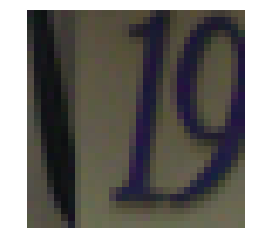

In [6]:
plt.imshow(train_X[:, :, :, 0])
plt.axis('off')
plt.show()

In [7]:
def stack_rgb(img):
    imgs = (img[:, :, 0], img[:, :, 1], img[:, :, 2])
    return np.concatenate(imgs, axis=1)

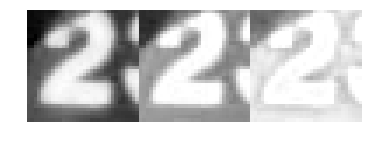

In [8]:
plt.imshow(stack_rgb(train_X[:, :, :, 2]), cmap='gray')
plt.axis('off')
plt.show()

In [9]:
# Standard NTSC/PAL luminance:
train_X_lum = 0.2989*train_X[:,:,0,:] + 0.5870*train_X[:,:,1,:] + 0.1140*train_X[:,:,2,:]
test_X_lum = 0.2989*test_X[:,:,0,:] + 0.5870*test_X[:,:,1,:] + 0.1140*test_X[:,:,2,:]

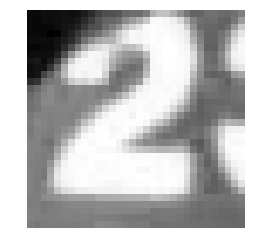

In [10]:
plt.imshow(train_X_lum[:, :, 2], cmap='gray')
plt.axis('off')
plt.show()

My guess:
- Luminance is meant to approximate the brightness we actually see. Images with similar luminance in foreground and background, but different colors, are probably then unlikely: it's just hard to read, and typically also ugly.
- However, color could still be a helpful proxy to help with foreground/background.

In [11]:
def normalize(images):
    """Converts input images to greyscale, and normalizes them
    (i.e. zero mean & unit variance for each pixel coordinate);
    returns a new array of images with shape (Y,X,N).
    
    Parameters:
    images -- Input array, shape (Y,X,3,N), for N color XxY images
    """
    r, g, b = images[:,:,0,:], images[:,:,1,:], images[:,:,2,:]
    img_lum = 0.2989*r + 0.5870*g + 0.1140*b
    # Note the axis=2. This normalization is per-pixel (though since
    # every pixel has been normalized, the aggregate mean & stdev
    # are also 0 and 1)
    mean = img_lum.mean(axis=2)[:,:,np.newaxis]
    stdev = img_lum.std(axis=2)[:,:,np.newaxis]
    img_norm = (img_lum - mean) / stdev
    return img_norm

In [12]:
train_X_norm = normalize(train_X)
train_X_norm.mean(), train_X_norm.std()

(1.0490779352118218e-15, 0.99999999999999878)

In [13]:
train_y.max()

10

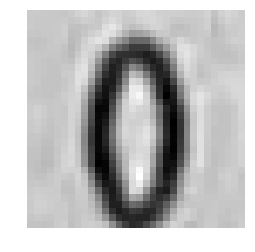

In [14]:
plt.imshow(train_X_lum[:,:,train_y == 10][:,:,4], cmap='gray')
plt.axis('off')
plt.show()

In [15]:
# Label of 10 appears to be the same as label of 0?
train_y[train_y == 10] = 0
train_y.max()

9

In [16]:
# Little lopsided (1 occurs 3 times as often as 0, 8, and 9):
for i in range(train_y.max() + 1):
    count = (train_y == i).sum()
    print("{0}: {1} ({2:.1f}%)".format(i, count, 100.0 * count / train_y.size))

0: 4948 (6.8%)
1: 13861 (18.9%)
2: 10585 (14.4%)
3: 8497 (11.6%)
4: 7458 (10.2%)
5: 6882 (9.4%)
6: 5727 (7.8%)
7: 5595 (7.6%)
8: 5045 (6.9%)
9: 4659 (6.4%)


## TensorFlow/Keras tests

In [17]:
import data_preprocessing

In [18]:
from tensorflow.python.client import device_lib

for x in device_lib.list_local_devices():
    print("{0.name}, {0.device_type}, {0.memory_limit}".format(x))

/cpu:0, CPU, 268435456
/device:XLA_CPU:0, XLA_CPU, 17179869184
/device:XLA_GPU:0, XLA_GPU, 17179869184
/device:XLA_EXEC:0, XLA_EXEC, 17179869184
/gpu:0, GPU, 5709365248


In [19]:
train_X_orig, train_y_orig, _, _ = data_preprocessing.load_data()
train_X_norm = data_preprocessing.normalize(train_X_orig)
train_X, valid_X, train_y, valid_y = data_preprocessing.split(
    train_X_norm, train_y_orig)
# 'split' is deterministic. If we want to look at the images later,
# we can pass the un-normalized ones in and it will correspond with
# the same split:
train_X_unnorm, valid_X_unnorm, _, _ = data_preprocessing.split(
    train_X_orig, train_y_orig)

In [20]:
# Adapted from:
# https://github.com/heuritech/convnets-keras/blob/master/convnetskeras/customlayers.py#L9
def lrn(alpha=1e-4, k=2, beta=0.75, n=5, **kwargs):
    def f(X):
        b, r, c, ch = X.shape
        half = n // 2
        square = keras.backend.square(X)
        # TODO: Fix padding here. The scale += ... line is failing.
        extra_channels = K.spatial_2d_padding(K.permute_dimensions(square, (0, 2, 3, 1)), ((0, 0), (half, half)))
        extra_channels = K.permute_dimensions(extra_channels, (0, 3, 1, 2))
        scale = k
        for i in range(n):
            scale += alpha * extra_channels[:, :, :, i:i + int(ch)]
        scale = scale ** beta
        return X / scale

    return Lambda(f, output_shape=lambda input_shape: input_shape, **kwargs)

In [21]:
def AlexNet(input_shape=(32, 32, 1), output_count=10, use_dropout=True):
    inputs = Input(shape=input_shape)

    #conv_1 = Conv2D(96, kernel_size=(11,11), strides=(4, 4), activation='relu', name='conv_1')(inputs)

    #conv_2 = MaxPooling2D((3, 3), strides=(2, 2))(conv_1)
    #conv_2 = lrn(name='convpool_1')(conv_2)
    #conv_2 = ZeroPadding2D((2, 2))(conv_2)
    #conv_2 = Conv2D(256, kernel_size=(5,5), activation='relu', name='conv_2')(conv_2)
    conv_2 = Conv2D(256, kernel_size=(5,5), activation='relu', name='conv_2')(inputs)
    conv_3 = MaxPooling2D((3, 3), strides=(2, 2))(conv_2)
    conv_3 = lrn()(conv_3)
    conv_3 = ZeroPadding2D((1, 1))(conv_3)
    conv_3 = Conv2D(384, kernel_size=(3, 3), activation='relu', name='conv_3')(conv_3)
    conv_4 = ZeroPadding2D((1, 1))(conv_3)
    conv_4 = Conv2D(384, kernel_size=(3, 3), activation='relu', name='conv_4')(conv_4)
    conv_5 = ZeroPadding2D((1, 1))(conv_4)
    conv_5 = Conv2D(128, kernel_size=(3, 3), activation='relu', name='conv_5')(conv_5)
    dense_1 = MaxPooling2D((3, 3), strides=(2, 2), name='convpool_5')(conv_5)
    dense_1 = Flatten(name='flatten')(dense_1)
    dense_1 = Dense(4096, activation='relu', name='dense_1')(dense_1)
    if use_dropout:
        dense_2 = Dropout(0.5)(dense_1)
    dense_2 = Dense(4096, activation='relu', name='dense_2')(dense_2)
    if use_dropout:
        dense_3 = Dropout(0.5)(dense_2)
    dense_3 = Dense(output_count, name='dense_3')(dense_3)
    prediction = Activation('softmax', name='softmax')(dense_3)

    model = Model(inputs=[inputs], outputs=[prediction])

    return model

In [22]:
alex = AlexNet()

In [23]:
# One-hot encode so they can be used for input/validation:
train_y_cat = keras.utils.to_categorical(train_y, num_classes=10)
valid_y_cat = keras.utils.to_categorical(valid_y, num_classes=10)

In [24]:
sgd = SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True)
alex.compile(loss='categorical_crossentropy',
             optimizer=sgd,
             metrics=['accuracy'])

In [25]:
train_X2 = np.expand_dims(train_X, axis=3)
valid_X2 = np.expand_dims(valid_X, axis=3)

class AccuracyHistory(keras.callbacks.Callback):
    """Keras callback for recording validation accuracy at regular
    intervals (i.e. every set number of batches)"""
    def __init__(self, test_X, test_y, skip=100):
        """Initialize an AccuracyHistory.  After training, the 'accuracy'
        property will contain a list of:
        (batch num, validation accuracy, training accuracy)
        
        Parameters:
        skip -- Interval (of batch number) at which to record accuracy
        test_X -- Input data for predicting accuracy
        test_y -- Correct labels corresponding to test_X
        """
        self.skip = skip
        self.accuracy = []
        self.test_X = test_X
        self.test_y = test_y
        self.i = 0
    def on_batch_end(self, batch, logs={}):
        self.i += 1
        if self.i % self.skip == 0:
            loss, val_acc = self.model.evaluate(self.test_X, self.test_y, verbose=0)
            self.accuracy.append((self.i, val_acc, logs.get("acc")))
acc_history = AccuracyHistory(valid_X2, valid_y_cat)

In [26]:
history = alex.fit(train_X2,
                   train_y_cat,
                   epochs=5,
                   batch_size=64,
                   callbacks=[acc_history],
                   validation_data=(valid_X2, valid_y_cat))

Train on 54942 samples, validate on 18315 samples
Epoch 1/5
54942/54942 [==============================] - 153s - loss: 0.9443 - acc: 0.6817 - val_loss: 0.4031 - val_acc: 0.8769
Epoch 2/5
54942/54942 [==============================] - 159s - loss: 0.3578 - acc: 0.8926 - val_loss: 0.3216 - val_acc: 0.9021
Epoch 3/5
54942/54942 [==============================] - 151s - loss: 0.2840 - acc: 0.9169 - val_loss: 0.2908 - val_acc: 0.9141
Epoch 4/5
54942/54942 [==============================] - 159s - loss: 0.2372 - acc: 0.9302 - val_loss: 0.2768 - val_acc: 0.9219
Epoch 5/5
54942/54942 [==============================] - 151s - loss: 0.1976 - acc: 0.9422 - val_loss: 0.2875 - val_acc: 0.9193


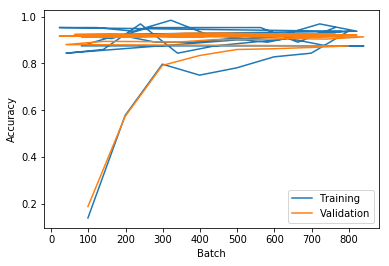

In [36]:
b = [i[0] for i in acc_history.accuracy]
plt.plot(b, [i[2] for i in acc_history.accuracy])
plt.plot(b, [i[1] for i in acc_history.accuracy])
#plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Batch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

In [28]:
alex.save_weights('alexnet_basic_20171129.h5')

In [29]:
valid_y_predict = np.argmax(alex.predict(valid_X2), axis=1)
# Confusion matrix (on validation set):
conf = sklearn.metrics.confusion_matrix(valid_y, valid_y_predict)
conf = pd.DataFrame(conf, columns=range(10), index=range(10))
conf

,0,1,2,3,4,5,6,7,8,9
0,1164,22,4,1,6,3,20,2,3,12
1,37,3262,24,13,39,9,19,40,11,11
2,15,32,2485,11,31,3,12,22,10,25
3,24,30,19,1837,15,93,32,12,43,19
4,11,40,12,8,1741,4,21,7,9,12
5,3,7,8,33,12,1570,54,1,9,24
6,26,10,3,0,5,23,1322,2,32,9
7,9,48,30,3,3,2,1,1296,0,7
8,24,20,8,8,5,9,45,4,1118,20
9,37,13,13,9,13,13,6,4,15,1042


In [30]:
# Adapted from:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

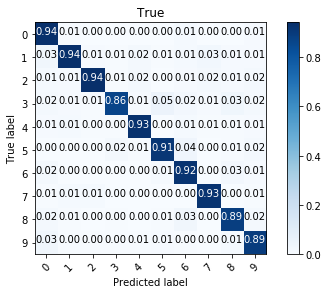

In [31]:
conf_norm = conf / conf.sum(axis=1)
plot_confusion_matrix(conf_norm.values, [str(i) for i in range(10)], True)
plt.show()

- It's also possible to show - in the same shape as the above matrix - an example of every misclassification:

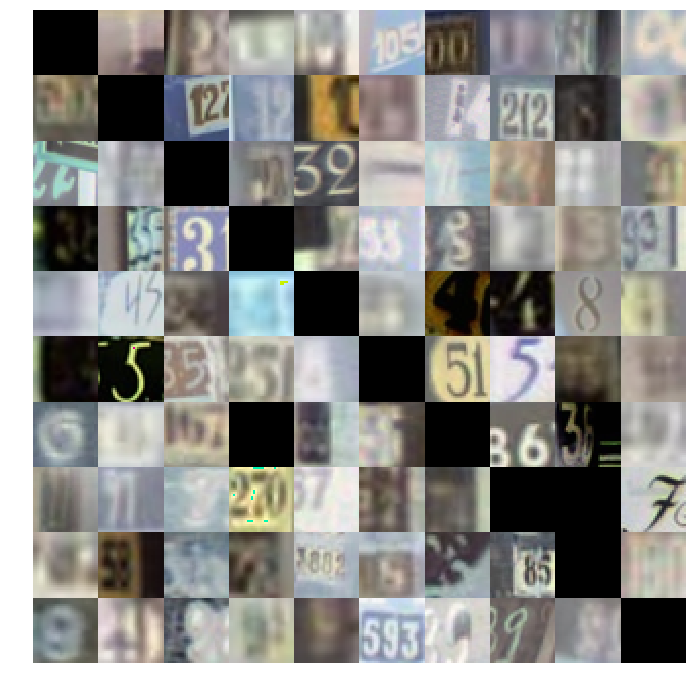

In [32]:
grid = np.zeros((32 * 10, 32 * 10, 3))
for i,j in [(i,j) for i in range(10) for j in range(10)]:
    # Leave diagonals blank (we don't care about correct ones):
    if i == j: continue
    # Find all cases where i is classified as j:
    idxs = ((valid_y == i) & (valid_y_predict == j)).nonzero()[0]
    # Pick one at random if one exists, and fill in grid:
    if idxs.size == 0: continue
    grid[(32*i):32*(i+1), (32*j):32*(j+1), :] = valid_X_unnorm[np.random.choice(idxs), :, :, :]
# I don't feel like wrangling matplotlib into showing this, so:
# Rows 0-9 are the correct labels.
# Columns 0-9 are the predicted labels.
plt.figure(figsize=(12,12))
plt.imshow(grid)
plt.axis('off')
plt.show()

Error classes:
- Multiple numbers
- Rotated, slanted, or sheared numbers
- Odd fonts, handwritten numbers
- Just too blurry to tell?

## Testing `graph_construction`

In [33]:
import graph_construction
import imp
graph_construction = imp.reload(graph_construction)

In [34]:
model, train_op, accuracy, x, y = graph_construction.classifier(0.02, True)